In [ ]:
from google.colab import files

uploaded = files.upload()  # pick your train.csv
train_path = next(iter(uploaded.keys()))
print("Using train file:", train_path)

Saving train.csv to train.csv
Using train file: train.csv


In [ ]:
uploaded = files.upload()  # pick your test.csv
test_path = next(iter(uploaded.keys()))
print("Using test file:", test_path)

Saving test.csv to test.csv
Using test file: test.csv


In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# ---------- 1. Load and inspect data ----------
def load_data(path="train.csv"):
    df = pd.read_csv(path)
    # We care about the user query (Question) and label (category)
    df = df[["Question", "category"]].dropna()
    return df


# ---------- 2. (Optional) basic preprocessing helper ----------
def simple_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9'?!.:, ]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


# ---------- 3. Build model pipeline ----------
def build_pipeline():
    """
    Pipeline = TF-IDF vectorizer + Logistic Regression classifier.
    Operates directly on raw text (we can hook simple_clean into it if desired).
    """
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=2,           # ignore very rare tokens
            max_df=0.9,         # ignore extremely frequent tokens (optional)
            # preprocessor=simple_clean,  # uncomment if you want our custom cleaning
        )),
        ("clf", LogisticRegression(
            max_iter=200,
            multi_class="multinomial",
            n_jobs=-1
        ))
    ])
    return pipe


# ---------- 4. Train / validation split ----------
def split_data(df):
    X = df["Question"]
    y = df["category"]
    # Stratify to keep class proportions similar in train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_val, y_train, y_val


# ---------- 5. Evaluation helpers ----------
def evaluate_model(model, X_val, y_val, label_order=None):
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    print("\n=== Accuracy ===")
    print(f"{acc:.4f}")

    print("\n=== Classification report (per-class precision/recall/F1) ===")
    print(classification_report(y_val, y_pred))

    print("=== Confusion matrix ===")
    cm = confusion_matrix(y_val, y_pred, labels=label_order)
    print(cm)

    # Plot confusion matrix nicely
    if label_order is None:
        label_order = sorted(np.unique(y_val))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=label_order, yticklabels=label_order)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Query Category Classifier")
    plt.tight_layout()
    plt.show()


# ---------- 6. Main script ----------
def main():
    print("Loading data...")
    df = load_data("train.csv")
    print(f"Dataset size: {len(df)}")
    print("Category distribution:")
    print(df["category"].value_counts())

    X_train, X_val, y_train, y_val = split_data(df)

    print("\nBuilding model...")
    model = build_pipeline()

    print("Training model...")
    model.fit(X_train, y_train)

    print("Evaluating model...")
    label_order = sorted(df["category"].unique())
    evaluate_model(model, X_val, y_val, label_order=label_order)

    # Example: predict category of new queries
    example_queries = [
        "Can you tell me a joke?",
        "I had a terrible day at work.",
        "Good afternoon, could you explain this concept?",
        "Hey! What's up?",
        "I'm so excited for my vacation!"
    ]
    print("\nExample predictions:")
    preds = model.predict(example_queries)
    for q, c in zip(example_queries, preds):
        print(f"  '{q}'  ->  {c}")

Loading data...
Dataset size: 20572
Category distribution:
category
caring          4151
friendly        4147
witty           4107
professional    4107
enthusiastic    4060
Name: count, dtype: int64

Building model...
Training model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating model...

=== Accuracy ===
0.0926

=== Classification report (per-class precision/recall/F1) ===
              precision    recall  f1-score   support

      caring       0.09      0.09      0.09       830
enthusiastic       0.10      0.10      0.10       812
    friendly       0.11      0.11      0.11       830
professional       0.09      0.09      0.09       822
       witty       0.08      0.08      0.08       821

    accuracy                           0.09      4115
   macro avg       0.09      0.09      0.09      4115
weighted avg       0.09      0.09      0.09      4115

=== Confusion matrix ===
[[ 72 186 194 193 185]
 [196  78 189 167 182]
 [173 167  91 193 206]
 [189 178 195  71 189]
 [184 196 195 177  69]]


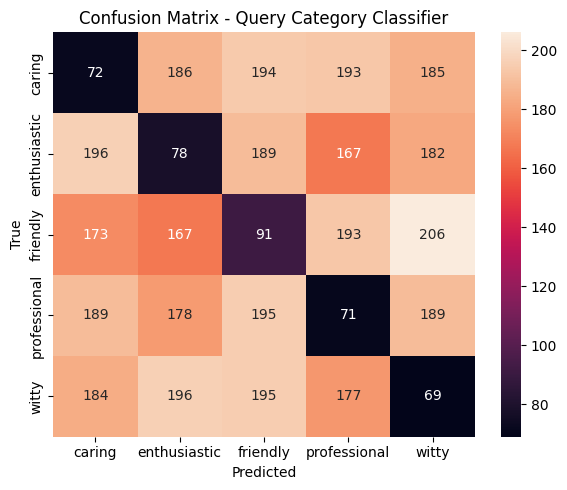


Example predictions:
  'Can you tell me a joke?'  ->  enthusiastic
  'I had a terrible day at work.'  ->  professional
  'Good afternoon, could you explain this concept?'  ->  caring
  'Hey! What's up?'  ->  professional
  'I'm so excited for my vacation!'  ->  enthusiastic


In [7]:
if __name__ == "__main__":
    main()